<a href="https://colab.research.google.com/github/Rishiatweb/Relevance-based-scoring/blob/main/Regression/UCI_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub
path = kagglehub.dataset_download("arpikr/uci-drug")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/uci-drug


In [2]:
!pip install -q transformers datasets evaluate accelerate
!pip install -q lightgbm

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import lightgbm as lgb
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
plt.style.use('seaborn-v0_8-whitegrid')

In [4]:
# ==============================================================================
#                 2. DATA INGESTION, CLEANING & PREPARATION
# ==============================================================================

import os
import shutil
import pandas as pd
import csv # Import for robust parsing options if needed later

# --- Step 2.1: Download and Unzip (Assuming this was done in Cell 1) ---
# ... This part of the code remains the same ...

# --- Step 2.2: Copy to a Writable Directory for Safe Processing ---
# Assuming 'path' is the variable from kagglehub.download
source_dir = path
writable_dir = "/content/drug_data_writable/"

print(f"\nCopying dataset from {source_dir} to {writable_dir}...")
if os.path.exists(writable_dir):
    shutil.rmtree(writable_dir) # Ensure a fresh start
shutil.copytree(source_dir, writable_dir)
print("Copying complete.")

# --- Step 2.3: Load Data from Writable Directory with CORRECT SEPARATOR ---
# Use the correct filenames from your previous code
TRAIN_FILE_PATH = os.path.join(writable_dir, 'UCIdrug_train.csv')
TEST_FILE_PATH = os.path.join(writable_dir, 'UCIdrug_test.csv')

print("\n--- Loading Data with Correct CSV Parser ---")

train_df = None
test_df = None

try:
    # THE FIX: Use sep=',' because these are CSV files.
    # We add on_bad_lines='skip' to gracefully handle any rows that are still malformed.
    train_df = pd.read_csv(TRAIN_FILE_PATH, sep=',', on_bad_lines='skip')
    test_df = pd.read_csv(TEST_FILE_PATH, sep=',', on_bad_lines='skip')
    print("Datasets loaded successfully.")

except Exception as e:
    print(f"A critical error occurred during file loading: {e}")
    print("This might indicate the files are not standard CSVs or have other formatting issues.")


# --- Step 2.4: Clean the Data ---
if train_df is not None:
    print("\nOriginal columns:", train_df.columns.tolist())

    # The first column is often an unnamed index column from the original save. Let's drop it.
    if 'Unnamed: 0' in train_df.columns:
        train_df = train_df.drop(columns=['Unnamed: 0'])
        test_df = test_df.drop(columns=['Unnamed: 0'])
        print("Dropped 'Unnamed: 0' index column.")

    print("\nMissing values before cleaning:\n", train_df.isnull().sum())

    # Fill missing 'condition' values with a placeholder
    placeholder = "Not Specified"
    train_df['condition'].fillna(placeholder, inplace=True)
    test_df['condition'].fillna(placeholder, inplace=True)

    # Drop any rows where the 'review' text itself is missing
    train_df.dropna(subset=['review'], inplace=True)
    test_df.dropna(subset=['review'], inplace=True)

    print("\nMissing values check after cleaning (should be all zeros except for columns we keep):")
    print(train_df.isnull().sum())
    print("\nData cleaning complete.")

    # --- Step 2.5: Prepare Final Datasets for Modeling ---
    X_train = train_df[['review', 'condition']]
    y_train = train_df['rating']

    X_test = test_df[['review', 'condition']]
    y_test = test_df['rating']

    print(f"\nData preparation complete. Training set size: {len(X_train)}, Test set size: {len(X_test)}")
else:
    print("\nData loading failed. Cannot proceed.")


Copying dataset from /kaggle/input/uci-drug to /content/drug_data_writable/...
Copying complete.

--- Loading Data with Correct CSV Parser ---
Datasets loaded successfully.

Original columns: ['uniqueID', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount']

Missing values before cleaning:
 uniqueID         0
drugName         0
condition      899
review           0
rating           0
date             0
usefulCount      0
dtype: int64

Missing values check after cleaning (should be all zeros except for columns we keep):
uniqueID       0
drugName       0
condition      0
review         0
rating         0
date           0
usefulCount    0
dtype: int64

Data cleaning complete.

Data preparation complete. Training set size: 161297, Test set size: 53766


<ipython-input-4-1271321316>:60: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['condition'].fillna(placeholder, inplace=True)
<ipython-input-4-1271321316>:61: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try u

In [5]:
# ==============================================================================
#                 3. TRAIN TRADITIONAL MODELS (MODELS 1 & 2)
# ==============================================================================

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import lightgbm as lgb

# --- Step 3.1: Define the Preprocessing Pipeline ---
# This pipeline handles both text and categorical features for our traditional models.
preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', TfidfVectorizer(stop_words='english', max_features=5000, ngram_range=(1, 2)), 'review'),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['condition'])
    ],
    remainder='drop'
)

# --- Step 3.2: Model 1 - Linear Regression (Ridge) ---
print("\n--- Training Model 1: Linear Regression ---")
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', Ridge(alpha=1.0))]) # Using Ridge for regularization

lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)
print("Linear Regression training complete.")

# --- Step 3.3: Model 2 - LightGBM ---
print("\n--- Training Model 2: LightGBM ---")
lgbm_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('regressor', lgb.LGBMRegressor(random_state=42, n_estimators=200))])

lgbm_pipeline.fit(X_train, y_train)
y_pred_lgbm = lgbm_pipeline.predict(X_test)
print("LightGBM training complete.")


--- Training Model 1: Linear Regression ---
Linear Regression training complete.

--- Training Model 2: LightGBM ---


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 10.272195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 762115
[LightGBM] [Info] Number of data points in the train set: 161297, number of used features: 5331
[LightGBM] [Info] Start training from score 6.994377


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM training complete.




      Final Model Performance Comparison
                   R-squared     MAE    RMSE
Model                                       
Linear Regression     0.4862  1.8690  2.3547
LightGBM              0.4719  1.8809  2.3873


<ipython-input-23-591318174>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df['R-squared'], ax=axes[0], palette='summer')
<ipython-input-23-591318174>:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df['MAE'], ax=axes[1], palette='autumn')
<ipython-input-23-591318174>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df['RMSE'], ax=axes[2], palette='winter')


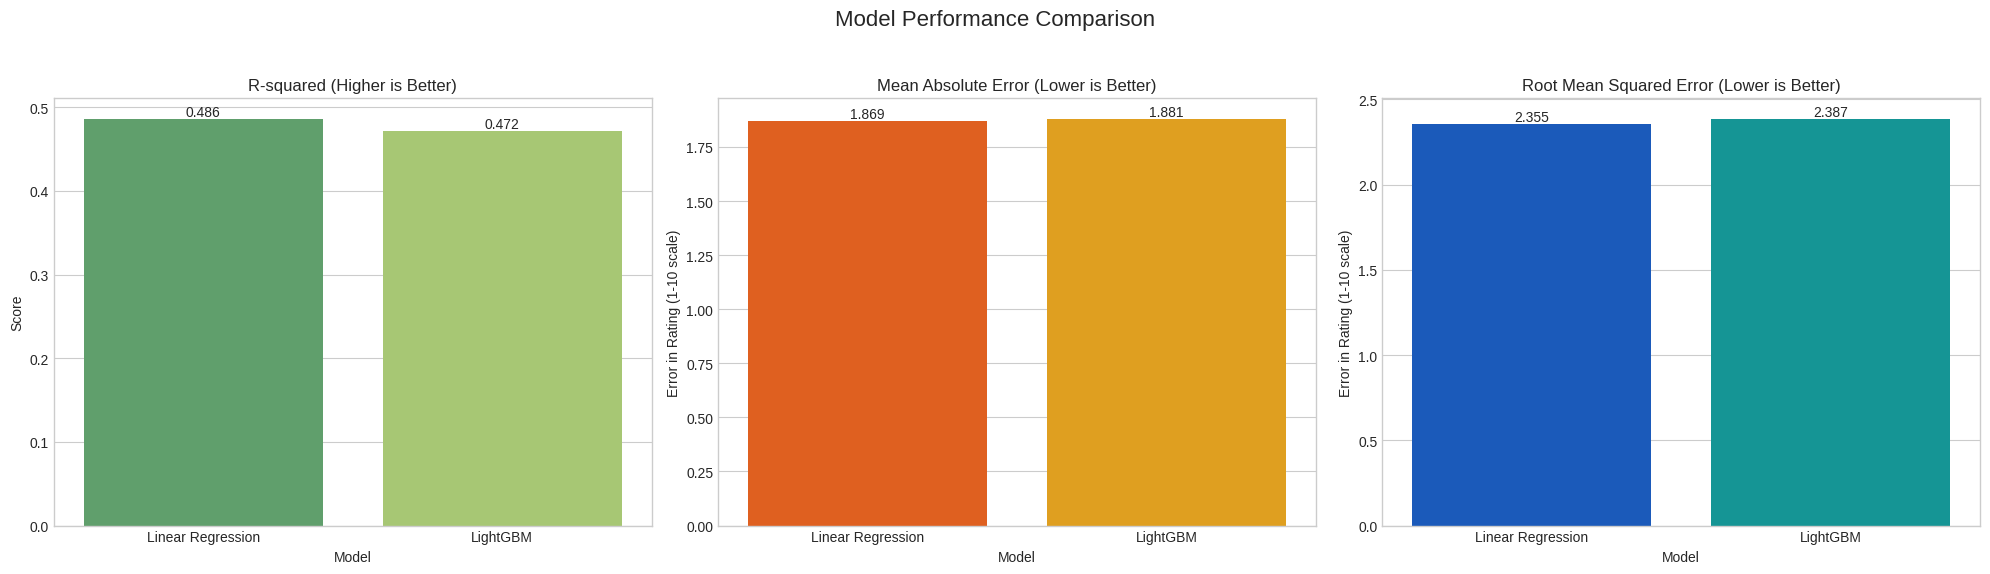

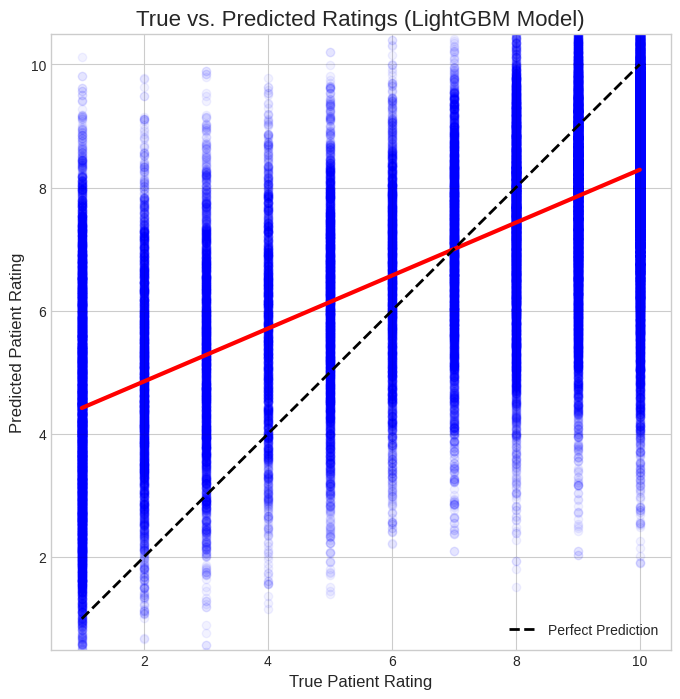

In [23]:
# ==============================================================================
#                 4. FINAL EVALUATION & VISUALIZATION
# ==============================================================================

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- Step 5.1: Calculate All Metrics ---
def calculate_regression_metrics(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"Model": model_name, "R-squared": r2, "MAE": mae, "RMSE": rmse}

# Get results for all three models
results_lr = calculate_regression_metrics(y_test, y_pred_lr, "Linear Regression")
results_lgbm = calculate_regression_metrics(y_test, y_pred_lgbm, "LightGBM")

# Combine into a single DataFrame for easy plotting and viewing
results_df = pd.DataFrame([results_lr, results_lgbm])
results_df.set_index('Model', inplace=True)

print("\n\n" + "="*50)
print("      Final Model Performance Comparison")
print("="*50)
print(results_df.round(4))

# --- Step 5.2: Visualize the Metrics ---
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=False)
fig.suptitle('Model Performance Comparison', fontsize=16)

# Plot R-squared
sns.barplot(x=results_df.index, y=results_df['R-squared'], ax=axes[0], palette='summer')
axes[0].set_title('R-squared (Higher is Better)')
axes[0].set_ylabel('Score')

# Plot MAE
sns.barplot(x=results_df.index, y=results_df['MAE'], ax=axes[1], palette='autumn')
axes[1].set_title('Mean Absolute Error (Lower is Better)')
axes[1].set_ylabel('Error in Rating (1-10 scale)')

# Plot RMSE
sns.barplot(x=results_df.index, y=results_df['RMSE'], ax=axes[2], palette='winter')
axes[2].set_title('Root Mean Squared Error (Lower is Better)')
axes[2].set_ylabel('Error in Rating (1-10 scale)')

# Add value labels to each bar
for ax in axes:
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.3f}',
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- Step 5.3: Visualize True vs. Predicted for the Best Model ---
# Let's assume LightGBM is the best traditional model
plt.figure(figsize=(8, 8))
sns.regplot(x=y_test, y=y_pred_lgbm,
            scatter_kws={'alpha':0.05, 'color':'blue'}, # Low alpha to see density
            line_kws={'color':'red', 'linewidth': 3})
plt.title('True vs. Predicted Ratings (LightGBM Model)', fontsize=16)
plt.xlabel('True Patient Rating', fontsize=12)
plt.ylabel('Predicted Patient Rating', fontsize=12)
plt.plot([1, 10], [1, 10], 'k--', lw=2, label='Perfect Prediction') # Diagonal line
plt.legend()
plt.xlim(0.5, 10.5)
plt.ylim(0.5, 10.5)
plt.grid(True)
plt.show()